### From tutorial https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_3.html

Use dataset from https://crcns.org/data-sets/vc/pvc-8

In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

import scipy.io
from pathlib import Path

In [2]:
num_steps = 200

In [3]:
# # create input spikes
# spk_in = spikegen.rate_conv(torch.rand((num_steps, num_inputs))).unsqueeze(1)
# print(spk_in.shape)
# print(spk_in[:, 0, 0]) # confirm that these are indeed spikes, i.e., binary

### Load data

In [4]:
# load input spike data
mat = scipy.io.loadmat(Path('data') / '01.mat') # animal 01
spike_train_all = mat['resp_train'] # spike train of all neurons, neurons x image x trials x milliseconds
print(spike_train_all.shape)

(102, 956, 20, 106)


In [5]:
# get subsets of spiking data
idx_small_nat_images = torch.zeros(spike_train_all.shape[1])
idx_small_nat_images[:539:2] = 1

idx_big_nat_images = torch.ones(spike_train_all.shape[1])
idx_big_nat_images[:539:2] = 0
idx_big_nat_images[540:] = 0

idx_gratings = torch.zeros(spike_train_all.shape[1])
idx_gratings[540:] = 1

In [6]:
# only keep well-centered channels
indcent = mat['INDCENT'].squeeze() # indicates if an stimulus was centered inside the neuron's RF and if the spikes were sorted
spike_train_cent = torch.tensor(spike_train_all[indcent == 1]) .float()
spike_train_cent.shape

torch.Size([26, 956, 20, 106])

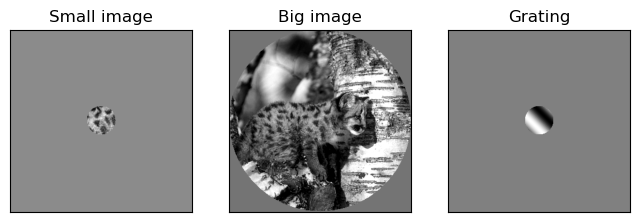

In [7]:
# get some sample images for each category
images_all = mat['images'].squeeze()
fig, ax = plt.subplots(1, 3, figsize=(8, 8))

fig_titles = ['Small image', 'Big image', 'Grating']
fig_idx = [538, 539, 600]
for i in range(3):
    ax[i].imshow(images_all[fig_idx[i]], cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(fig_titles[i])

plt.show()

### Simulate network

In [8]:
# layer parameters
num_inputs = spike_train_cent.shape[0] # train on all channels
num_hidden = 256
num_outputs = images_all[0].flatten().shape[0]
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta) # threshold is 1.0 by default
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

In [9]:
# Initialize hidden states
mem1 = lif1.reset_mem()
mem2 = lif2.reset_mem()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

In [10]:
# set up spike, use spikes on a big image, concatenate the trials
spk_in = spike_train_cent[:, 539, :, :].squeeze()
spk_in = spk_in.reshape(spk_in.shape[0], -1)
spk_in = spk_in.reshape(spk_in.shape[-1], 1, spk_in.shape[0]) # input shape must be n_times x n_batches x n_channels
print(spk_in.shape)

torch.Size([2120, 1, 26])


In [11]:
# network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

In [12]:
def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in, ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec, ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec, ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])
  ax[2].set_xlabel('Time')  
    
  plt.show()     

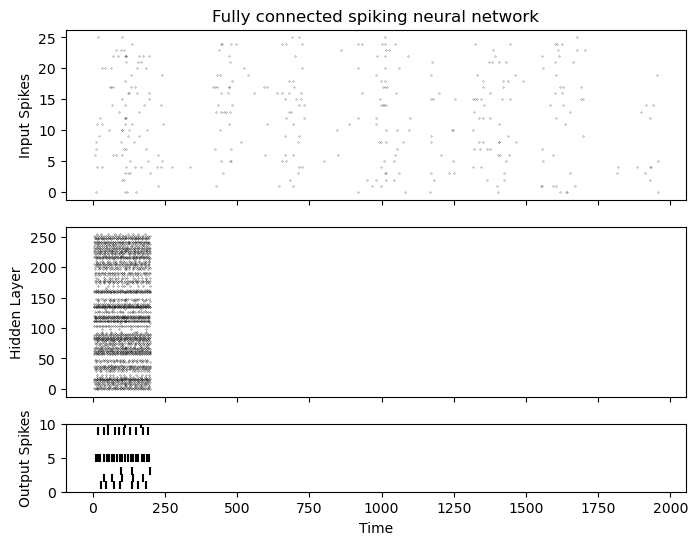

In [13]:
plot_snn_spikes(spk_in.squeeze(), spk1_rec.squeeze(), spk2_rec.squeeze(), 'Fully connected spiking neural network')

In [16]:
spk1_rec.shape

torch.Size([200, 1, 256])